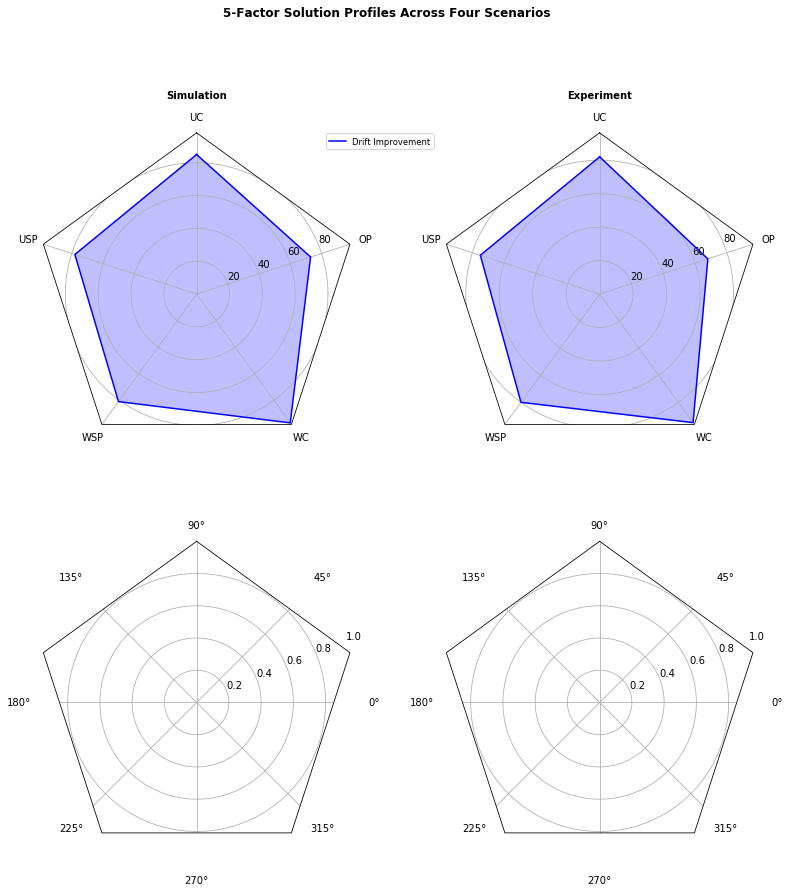

In [1]:
"""
======================================
Radar chart (aka spider or star chart)
======================================

This example creates a radar chart, also known as a spider or star chart [1]_.

Although this example allows a frame of either 'circle' or 'polygon', polygon
frames don't have proper gridlines (the lines are circles instead of polygons).
It's possible to get a polygon grid by setting GRIDLINE_INTERPOLATION_STEPS in
matplotlib.axis to the desired number of vertices, but the orientation of the
polygon is not aligned with the radial axes.

.. [1] http://en.wikipedia.org/wiki/Radar_chart
"""
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    # rotate theta such that the first axis is at the top
    theta += np.pi/2

    def draw_poly_patch(self):
        verts = unit_poly_verts(theta)
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_patch(self):
        # unit circle centered on (0.5, 0.5)
        return plt.Circle((0.5, 0.5), 0.5)

    patch_dict = {'polygon': draw_poly_patch, 'circle': draw_circle_patch}
    if frame not in patch_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_patch = patch_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            return self.draw_patch()

        def _gen_axes_spines(self):
            if frame == 'circle':
                return PolarAxes._gen_axes_spines(self)
            # The following is a hack to get the spines (i.e. the axes frame)
            # to draw correctly for a polygon frame.

            # spine_type must be 'left', 'right', 'top', 'bottom', or `circle`.
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            # close off polygon by repeating first vertex
            verts.append(verts[0])
            path = Path(verts)

            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta


def unit_poly_verts(theta):
    """Return vertices of polygon for subplot axes.

    This polygon is circumscribed by a unit circle centered at (0.5, 0.5)
    """
    x0, y0, r = [0.5] * 3
    verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
    return verts


def example_data():
    # The following data is from the Denver Aerosol Sources and Health study.
    # See  doi:10.1016/j.atmosenv.2008.12.017
    #
    # The data are pollution source profile estimates for five modeled
    # pollution sources (e.g., cars, wood-burning, etc) that emit 7-9 chemical
    # species. The radar charts are experimented with here to see if we can
    # nicely visualize how the modeled source profiles change across four
    # scenarios:
    #  1) No gas-phase species present, just seven particulate counts on
    #     Sulfate
    #     Nitrate
    #     Elemental Carbon (EC)
    #     Organic Carbon fraction 1 (OC)
    #     Organic Carbon fraction 2 (OC2)
    #     Organic Carbon fraction 3 (OC3)
    #     Pyrolized Organic Carbon (OP)
    #  2)Inclusion of gas-phase specie carbon monoxide (CO)
    #  3)Inclusion of gas-phase specie ozone (O3).
    #  4)Inclusion of both gas-phase species is present...
    data = [
        ['UC', 'USP', 'WSP', 'WC', 'OP'],
        ('Simulation', [
            [85, 78, 81, 97, 73]]),
        ('Experiment', [
            [82, 75, 80, 95, 68]]),
    ]
    return data


if __name__ == '__main__':
    N = 5
    theta = radar_factory(N, frame='polygon')

    data = example_data()
    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(13, 13), nrows=2, ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flatten(), data):
        #ax.set_rgrids([60, 80, 90, 100])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    ax = axes[0, 0]
    labels = ['Drift Improvement']
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import mpld3
import matplotlib.patches as mpatches
mpld3.enable_notebook();

# Set default plot size
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

def add_legend_for_empty_markers(data, hue, palette=None, ax=None):
    palette = palette or sns.color_palette("Set1")  # TODO: Get current palette
    ax = ax or plt.gca()
    
    handles = []  # I assume nothing else was going into the legend.
    # Made-up logic to match responses to colors. Works; fragile.
    for response, color in zip(set(data[hue].values), palette[1::3]):
        handles.append(mlines.Line2D([], [], color=color, marker="", label=response))
    ax.legend(handles=handles, title=hue)

#matplotlib.rc('font', **font)
sWC1 =  [97, 95, 98, 95, 96];
sWC2 =  [87, 85, 88, 85, 86];
sWC3 =  [77, 75, 78, 75, 76];
sWC4 =  [67, 65, 68, 65, 66];

sBA1 =  [85, 91, 90, 92, 90];
sBA2 =  [75, 81, 79, 82, 70];
sBA3 =  [65, 71, 69, 72, 60];
sBA4 =  [55, 61, 59, 62, 50];

sUC1 =  [85, 82, 86, 83, 84];
sUC2 =  [75, 72, 76, 73, 74];
sUC3 =  [65, 62, 66, 63, 64];
sUC4 =  [55, 52, 56, 53, 54];

sWSP1 = [80, 81, 83, 84, 82];
sWSP2 = [70, 71, 73, 74, 72];
sWSP3 = [60, 61, 63, 64, 62];
sWSP4 = [50, 51, 53, 54, 52];

sUSP1 = [78, 79, 80, 77, 79];
sUSP2 = [68, 69, 70, 67, 69];
sUSP3 = [58, 59, 50, 57, 59];
sUSP4 = [48, 49, 50, 47, 69];

sOP1 =  [70, 74, 70, 75, 77];
sOP2 =  [60, 64, 60, 65, 67];
sOP3 =  [50, 54, 40, 35, 57];
sOP4 =  [30, 34, 30, 35, 37];



maxi = 100;

simacc1 = [sWC1, sBA1, sUC1, sWSP1, sUSP1, sOP1]
simacc2 = [sWC2, sBA2, sUC2, sWSP2, sUSP2, sOP2]
simacc3 = [sWC3, sBA3, sUC3, sWSP3, sUSP3, sOP3]
simacc4 = [sWC4, sBA4, sUC4, sWSP4, sUSP4, sOP4]

#while True:
#    try:
###        simacc1.append(100-sWC.pop(0))
#        simacc2.append(100-sBA.pop(0))
#        simacc3.append(100-sUC.pop(0))
#        simacc4.append(100-sWSP.pop(0))
#        simacc5.append(100-sUSP.pop(0))
#        simacc6.append(100-sOP.pop(0))
#    except IndexError:
#        break

#simacc = simacc1 + simacc2 + simacc3 + simacc4 + simacc5 + simacc6


eWC = [93, 98, 91, 92, 92];
eBA = [82, 89, 87, 86, 90];
eUC = [88, 85, 85, 80, 81];
eWSP = [78, 83, 81, 82, 80];
eUSP = [79, 79, 77, 76, 77];
eOP = [73, 71, 73, 75, 77];

expacc = []
maxe = 99;
while True:
    try:
        expacc.append(100-eWC.pop(0))
        expacc.append(100-eBA.pop(0))
        expacc.append(100-eUC.pop(0))
        expacc.append(100-eWSP.pop(0))
        expacc.append(100-eUSP.pop(0))
        expacc.append(100-eOP.pop(0))
    except IndexError:
        break

WC = [1] * 5;
BA = [2] * 5;
UC = [3] * 5;
WSP = [4] * 5;
USP = [5] * 5;
OP = [6] * 5;

methods = WC + BA + UC + WSP + USP + OP;

d1 = ['D = 0.68, 143 edges'] * 30;
d2 = ['D = 0.51, 108 edges'] * 30;
d3 = ['D = 0.34,  73 edges'] * 30;
d4 = ['D = 0.18,  38 edges'] * 30;

#densities = d1 + d2 + d3 + d4;


simacc1 = np.concatenate( simacc1, axis=0 )
simacc2 = np.concatenate (simacc2, axis=0)
simacc3 = np.concatenate( simacc3, axis=0 )
simacc4 = np.concatenate (simacc4, axis=0)

simacc1 = 100 - simacc1;
simacc2 = 100 - simacc2;
simacc3 = 100 - simacc3;
simacc4 = 100 - simacc4;



sim = [simacc1] + [simacc2] + [simacc3] + [simacc4];
sim = np.concatenate( sim, axis=0 )
m = methods * 4;
d = d1 + d2 + d3 + d4;

sd = {'Drift Error (%)': sim, 'Methods':m, 'Density':d}
#sd1 = {'Drift Error (%)': simacc1, 'Methods':methods, 'Density':d1}
#sd2 = {'Drift Error (%)': simacc2, 'Methods':methods, 'Density':d2}
#sd3 = {'Drift Error (%)': simacc3, 'Methods':methods, 'Density':d3}
#sd4 = {'Drift Error (%)': simacc4, 'Methods':methods, 'Density':d4}

#print(sd)
#ed = {'Drift Error (%)': expacc, 'Methods':Methods, 'Density', densities};
#ed = {'UC': eWC, 'UC': eUC, 'WSP':eWSP, 'sUSP':eUSP, 'sOP':eOP};
sim = pd.DataFrame(data=sd)
#sim1 = pd.DataFrame(data=sd1)
#sim2 = pd.DataFrame(data=sd2)
#sim3 = pd.DataFrame(data=sd3)
#sim4 = pd.DataFrame(data=sd4)
#sim = sim['Methods'].apply(pd.to_numeric, errors='coerce') 
#print(sim)
#print(sim1)
sns.set(font_scale=2)
#exp = pd.DataFrame(data=ed)
sns.set_style("whitegrid",{'legend.frameon':True})
#ax = sns.lmplot(sim1['Methods'], sim1['Drift Error (%)'], data=sim1, legend_out=True);
ax = sns.factorplot(x="Methods", y="Drift Error (%)", 
                hue="Density", 
                x_estimator=np.mean, 
                scatter_kws={"s": 100},
                data=sim, 
                legend=False,
                aspect=1.5,
                size=6);

plt.legend(loc="Best")
#ax.legend(loc="Best")
#ax = sns.lmplot(x="Methods", y="Drift Error (%)", hue="Density", x_estimator=np.mean, scatter_kws={"s": 100} ,data=sim2);
#ax = sns.lmplot(x="Methods", y="Drift Error (%)", hue="Density", x_estimator=np.mean, scatter_kws={"s": 100} ,data=sim3);
#ax = sns.lmplot(x="Methods", y="Drift Error (%)", hue="Density", x_estimator=np.mean, scatter_kws={"s": 100} ,data=sim4);

#ax.set_ylim([0, 60])
#ax.set_xlabel("Method",fontsize=20)
#ax.set_ylabel("Mean Absolute Error (ms)",fontsize=20)
ticks = ["WC", "BA", "UC", "WSP", "USP", "OP"]
count = 0;
for axx in ax.axes.flatten():
    axx.set_xticklabels(ticks);
   # for tick in axx.get_xticklabels():
   #     tick.setxticklabels(ticks)
       
#red_patch = mpatches.Patch(label='The red data')
#ax.tick_params(labelsize=20)
#ax.legend()
#print(sim)
#plt.ylabel("Accuracy (%)")
#plt.xlabel("Method")
#plt.ylim([0,100])
sns.plt.show()

C:\Users\Ala\Anaconda3\lib\site-packages\matplotlib\legend.py:326: UserWarning: Unrecognized location "Best". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  six.iterkeys(self.codes))))


In [26]:
import matplotlib
import matplotlib.pyplot as plt
import mpld3
mpld3.enable_notebook();
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 15}

matplotlib.rc('font', **font)
# Set default plot size
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
## NCC vs DTW results
Tncc = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1];
Tdtw = Tncc;
tru = [5,5,5,5,5,5,5,5,5,5,5];
# number of captured activities
Ancc = [[10, 10, 9, 8, 8, 7, 6, 5, 3, 3, 1], [10, 9, 8, 8, 7, 7, 7, 5, 3, 2, 0], [10, 9, 9, 8, 7, 7, 6, 5, 3, 2, 1], [10, 10, 8, 8, 7, 6, 6, 5, 4, 3, 0], [10, 10, 9, 8, 7, 6, 5, 5, 4, 3, 2]];
Adtw = [[0, 2, 3, 5, 6, 7, 7, 8, 8, 9, 10], [0, 3, 4, 5, 7, 7, 8, 8, 9, 9, 10], [0, 2, 4, 5, 6, 7, 8, 9, 9 , 10, 10], [0, 1, 2, 5 ,7 ,7 ,8, 8 ,9 ,9 ,10], [0, 2, 3, 5, 5, 6, 6, 7, 8, 9, 10]];
fig, (ax1, ax2) = plt.subplots(ncols=2);
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=4)
ax1.plot(Tncc, Ancc[0], 'r*-', label="Subject 1");
ax1.plot(Tncc, Ancc[1], 'bs-', label="Subject 2");
ax1.plot(Tncc, Ancc[2], 'gd-', label="Subject 3");
ax1.plot(Tncc, Ancc[3], 'm+-', label="Subject 4");
ax1.plot(Tncc, Ancc[4], 'cv-', label="Subject 5");
ax1.plot(Tncc, tru, 'r--');
ax1.legend()
ax1.grid()
ax1.set_title("NCC")
ax1.set_xlabel("NCC Threshold");
ax1.set_ylabel("Number of Similar Activities Detected");

ax2.plot(Tdtw, Adtw[0], 'r*-', label="Subject 1");
ax2.plot(Tdtw, Adtw[1], 'bs-', label="Subject 2");
ax2.plot(Tdtw, Adtw[2], 'gd-', label="Subject 3");
ax2.plot(Tdtw, Adtw[3], 'm+-', label="Subject 4");
ax2.plot(Tdtw, Adtw[4], 'cv-', label="Subject 5");
ax2.plot(Tncc, tru, 'r--');
ax2.legend()
ax2.grid()
ax2.set_title("DTW")
ax2.set_xlabel("DTW Threshold");
ax2.set_ylabel("Number of Similar Activities Detected");

plt.show()

C:\Users\Ala\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1297: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
